# **Imports**

In [1]:
import matplotlib.pyplot as plt
import matplotlib.dates as mdates # Import the mdates module
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
import seaborn as sns
import datetime
import google.colab
import os

**Reading data from drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Reading HRV samples



```
Reading the dataframe
```



In [3]:
heartrate_df_orig = pd.read_csv("/content/drive/MyDrive/project/heartrate_seconds_merged.csv")
heartrate_df = heartrate_df_orig.copy()

## Understanding the data

In [4]:
heartrate_df

,Id,Time,Value
0,2022484408,4/12/2016 7:21:00 AM,97
1,2022484408,4/12/2016 7:21:05 AM,102
2,2022484408,4/12/2016 7:21:10 AM,105
3,2022484408,4/12/2016 7:21:20 AM,103
4,2022484408,4/12/2016 7:21:25 AM,101
...,...,...,...
2483653,8877689391,5/12/2016 2:43:53 PM,57
2483654,8877689391,5/12/2016 2:43:58 PM,56
2483655,8877689391,5/12/2016 2:44:03 PM,55
2483656,8877689391,5/12/2016 2:44:18 PM,55


## People-Date dafaframes generation

**Creates a dataframe for each person**

In [5]:
##############################################################################
num_unique_ids = heartrate_df["Id"].nunique()
print(f"Number of unique Ids: {num_unique_ids}") #prints the number of people
##############################################################################
unique_ids = heartrate_df["Id"].unique()
##############################################################################
# Create sub-DataFrames with new labels
id_mapping = {id_val: f"p{i+1}" for i, id_val in enumerate(unique_ids)}
id_dataframes = {id_mapping[id_val]: df for id_val, df in heartrate_df.groupby("Id")}
##############################################################################
# Display the mapping of original Ids to new labels
for original_id in sorted(id_mapping, key=lambda id_: (heartrate_df["Id"] == id_).sum(), reverse=True):
    new_label = id_mapping[original_id]
    id_count = (heartrate_df["Id"] == original_id).sum()
    print(f"{original_id} -> {new_label}, sample count: {id_count}")
#id_dataframes["p14"]

Number of unique Ids: 14
4020332650 -> p4, sample count: 285461
6962181067 -> p11, sample count: 266326
5553957443 -> p7, sample count: 255174
4388161847 -> p5, sample count: 249748
5577150313 -> p8, sample count: 248560
8877689391 -> p14, sample count: 228841
4558609924 -> p6, sample count: 192168
6117666160 -> p9, sample count: 158899
2022484408 -> p1, sample count: 154104
2347167796 -> p3, sample count: 152683
7007744171 -> p12, sample count: 133592
8792009665 -> p13, sample count: 122841
6775888955 -> p10, sample count: 32771
2026352035 -> p2, sample count: 2490


**Splits for days for each person**

In [6]:
for i in range(1, 15):  # Loop for p1 to p14
    # Create person DataFrame
    globals()[f"p{i}_df"] = id_dataframes[f"p{i}"]
    # Extract and group by Date
    globals()[f"p{i}_days_dataframes"] = {
        date: sub_df for date, sub_df in globals()[f"p{i}_df"]
        .assign(Date=pd.to_datetime(globals()[f"p{i}_df"]["Time"], format="%m/%d/%Y %I:%M:%S %p").dt.date)
        .groupby("Date")
    }
    # Create dynamic variables for df_pn_dayk
    for date, sub_df in globals()[f"p{i}_days_dataframes"].items():
        globals()[f"df_p{i}_day{date.strftime('%Y%m%d')}"] = sub_df

**Code Examples on how to access the data:**

In [13]:
#How to access the data and read it per-person-per-date: example:
################################################################################
#how to access to all data of person number 1:
#option 1:
#p14_df
#option 2:
#id_dataframes["p14"]
################################################################################

#How to read the List of Available Days for a Person:
#p1_days_dataframes ## Dictionary of daily data for person 1

################################################################################

#print(list(p1_days_dataframes.keys()))  # Show available days for person 1

################################################################################

#How to see data of person on a specific date:
#df_p1_day20160412  # Data for person 1 on April 12, 2016

################################################################################

## Data Analysis

How many samples each person has for each day:

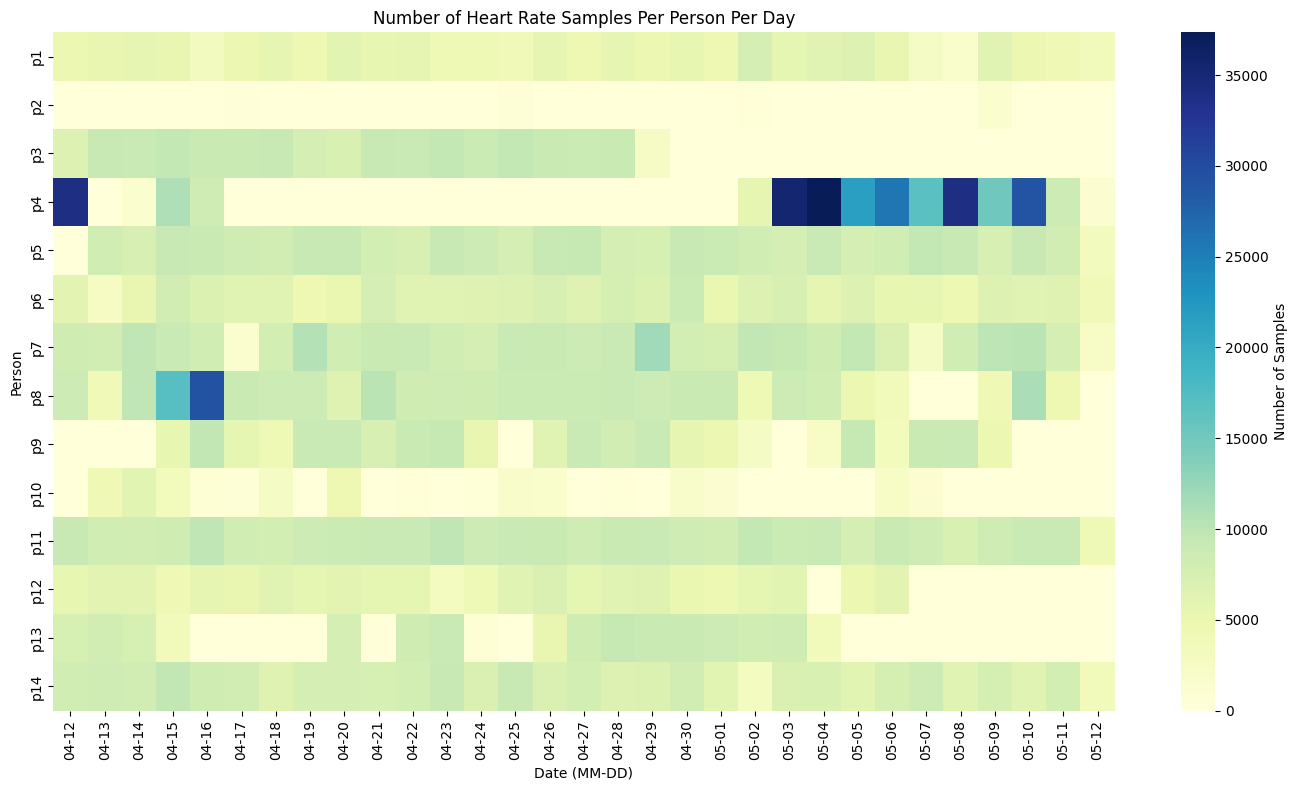

In [8]:
df = heartrate_df.copy()
df['Time'] = pd.to_datetime(df['Time'])
# Extract date
df['Date'] = df['Time'].dt.date
# Apply mapping to dataset
df['Person'] = df['Id'].map(id_mapping)
df = df[df['Person'].notna()]  # Keep only mapped users
# Count samples per day per person
user_day_matrix = df.groupby(['Date', 'Person']).size().unstack(fill_value=0)
# Ensure correct person order
ordered_people = [f'p{i}' for i in range(1, 15)]
user_day_matrix = user_day_matrix[ordered_people]
# Reformat index to remove year (show MM-DD only)
user_day_matrix.index = pd.to_datetime(user_day_matrix.index)
user_day_matrix.index = user_day_matrix.index.strftime('%m-%d')
# Plot heatmap
plt.figure(figsize=(14, 8))
sns.heatmap(user_day_matrix.T, cmap="YlGnBu", cbar_kws={'label': 'Number of Samples'})
plt.title("Number of Heart Rate Samples Per Person Per Day")
plt.xlabel("Date (MM-DD)")
plt.ylabel("Person")
plt.tight_layout()
plt.show()

As we can see, person 4 has many data on the blue days, we need to ask ourselves what is the sample rate we want to take for our data

## Plotting functions

### Plotting for all days for a specific person:

In [14]:
def plot_days_for_person(person_num):
  var_name = f"p{person_num}_days_dataframes"
  pn_days_dataframes = globals()[var_name]
  # Get all available days for person 1
  days_pn = list(pn_days_dataframes.keys())
  # Set up subplots in a grid layout
  num_days = len(days_pn)
  cols = 3  # Number of columns
  rows = -(-num_days // cols)  # Ceiling division to determine rows
  fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3), sharey=True)
  axes = axes.flatten()  # Flatten the array of axes for easy iteration
  # Plot heart rate signal for each day
  for i, day in enumerate(days_pn):
      day_df = pn_days_dataframes[day].copy()  # Copy to avoid modifying original
      # Convert 'Time' to datetime if it's not already
      if not pd.api.types.is_datetime64_any_dtype(day_df["Time"]):
          day_df["Time"] = pd.to_datetime(day_df["Time"], format="%m/%d/%Y %I:%M:%S %p", errors='coerce')
      # Extract time and convert to numerical format (hours since start of day)
      day_df["TimeNum"] = day_df["Time"].dt.hour + day_df["Time"].dt.minute / 60 + day_df["Time"].dt.second / 3600
      axes[i].plot(day_df["TimeNum"], day_df["Value"], marker="o", linestyle="-", markersize=3, alpha=0.7)
      axes[i].set_title(f"Day: {day}", fontsize=10)
      axes[i].set_xlabel("Time (hours)", fontsize=8)  # Updated x-axis label
      axes[i].set_ylabel("Heart Rate", fontsize=8)
      axes[i].grid(True, linestyle="--", alpha=0.6)
      # Dynamically set x-axis limits based on first and last measurement times
      axes[i].set_xlim(day_df["TimeNum"].min(), day_df["TimeNum"].max())
  # Hide empty subplots if any
  for j in range(i + 1, len(axes)):
      fig.delaxes(axes[j])
  plt.tight_layout()
  plt.show()

#plot_days_for_person(1)

### Plotting for one specific person, on a one specific date:

In [15]:
def plot_heart_rate(n, date_str):
    """
    Plots the heart rate signal for a given person (n) on a specified date (YYYYMMDD)
    with high resolution and zoom functionality."""
    # Generate the correct key to access the DataFrame
    df_key = f"df_p{n}_day{date_str}" # Check if the DataFrame exists in the global scope
    if df_key not in globals():
        print(f"Error: No data available for Person {n} on {date_str}.")
        return # Retrieve the DataFrame
    df = globals()[df_key].copy() # Checks if 'Time' and 'Value' columns exist
    if "Time" not in df.columns or "Value" not in df.columns:
        print(f"Error: Missing 'Time' or 'Value' column in data for Person {n} on {date_str}.")
        return
    # Debugging: Show first few rows
    #print("Initial Data Preview:")
    #print(df.head())
    # Convert 'Time' column to string before parsing
    df["Time"] = df["Time"].astype(str) # Convert 'Time' to datetime format
    df["Time"] = pd.to_datetime(df["Time"], format="%m/%d/%Y %I:%M:%S %p", errors='coerce')
    df = df.dropna(subset=["Time"]) # Drop rows where 'Time' couldn't be converted
    # Ensure 'Value' column has valid numeric values
    df["Value"] = pd.to_numeric(df["Value"], errors="coerce")
    df = df.dropna(subset=["Value"])
    # Check if any valid data remains
    if df.empty:
        print(f"Error: No valid time or heart rate data for Person {n} on {date_str}.")
        return
    # Convert 'Time' to numerical format (hours + minutes as decimal)
    df["TimeNum"] = df["Time"].dt.hour + df["Time"].dt.minute / 60
    # Debugging: Show processed data preview
    #print("Processed Data Preview:")
    #print(df.head())
    # Create the plot
    plt.figure(figsize=(10, 5), dpi=300)  # High DPI for clear visuals
    plt.plot(df["TimeNum"], df["Value"], marker="o", linestyle="-", markersize=3, alpha=0.7)
    # Formatting
    plt.title(f"Heart Rate for Person {n} on {date_str}", fontsize=14)
    plt.xlabel("Time (Hours)", fontsize=12)
    plt.ylabel("Heart Rate", fontsize=12)
    plt.xticks(range(0, 25, 2))  # Show x-axis ticks every 2 hours
    plt.grid(True, linestyle="--", alpha=0.6)
    plt.xlim(df["TimeNum"].min(), df["TimeNum"].max()) # Set x-axis limits from first to last recorded time
    plt.tight_layout() # Adjust layout to avoid overlap
    plt.show(block=True) #Ensures the plot renders

# Example Usage
#plot_heart_rate(4, "20160504")  # Plot for Person 1 on April 12, 2016


### Plot any signal:

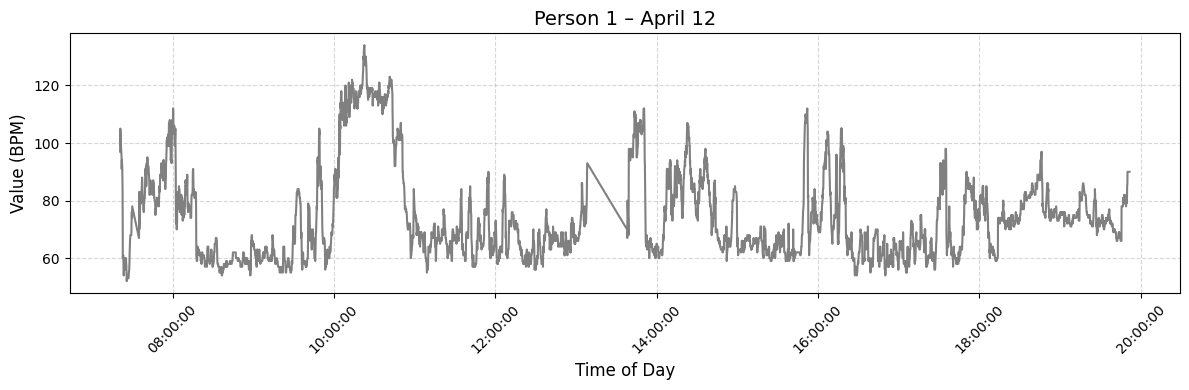

In [17]:
import matplotlib.dates as mdates

def plot_signal(df, title="Heart Rate Signal"):
    df = df.copy()
    # Parse full datetime from 'Time' column
    df['datetime'] = pd.to_datetime(df['Time'], format="%m/%d/%Y %I:%M:%S %p")

    plt.figure(figsize=(12, 4))

    # Use gray-style settings here
    plt.plot(
        df['datetime'], df['Value'],
        linestyle='-',
        color='gray',             # Gray line
        markersize=6,
        markerfacecolor='white',  # White fill to match gray theme
        markeredgecolor='black',
        linewidth=1.5
    )

    plt.title(title, fontsize=14)
    plt.xlabel("Time of Day", fontsize=12)
    plt.ylabel("Value (BPM)", fontsize=12)

    # Format x-axis to show only HH:MM:SS
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
    plt.xticks(rotation=45)
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()
plot_signal(df_p1_day20160412, title="Person 1 – April 12")

In [18]:
#def plot_signal1(df, title="Heart Rate Signal"):
#    df = df.copy()
    # Parse full datetime from 'Time' column
#    df['datetime'] = pd.to_datetime(df['Time'], format="%m/%d/%Y %I:%M:%S %p")
    # Plot using datetime
#    plt.figure(figsize=(12, 4))
#    plt.plot(
#        df['datetime'], df['Value'],
#        marker='o',
#        linestyle='-',
#        markersize=6,           # Bigger marker size
#        markerfacecolor='blue', # Fill color
#        markeredgecolor='black',# Border color
#        linewidth=1.5           # Slightly thicker line
#    )
#    plt.title(title)
#    plt.xlabel("Time of Day")
#    plt.ylabel("Value (BPM)")
    # Format x-axis to show only HH:MM:SS
#    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))
#    plt.xticks(rotation=45)
#    plt.grid(True)
#    plt.tight_layout()
#    plt.show()

#Usage Example:
#plot_signal1(df_p1_day20160412, title="Person 1 – April 12")

# Sample generation

##### So Let's try to eximine different time intervals:

In [19]:
def split_day_by_gap(person_num, date_str, max_gap_seconds=30, threshold=0):
    # Access the existing variable dynamically
    var_name = f"df_p{person_num}_day{date_str}"
    df = globals()[var_name].copy()
    # Parse 'Time' only (it already includes full date in MM/DD/YYYY format)
    df['datetime'] = pd.to_datetime(df['Time'], format="%m/%d/%Y %I:%M:%S %p")
    # Calculate time difference between consecutive rows
    df['time_diff'] = df['datetime'].diff().dt.total_seconds().fillna(0)
    # Create a group id that increments when gap exceeds max_gap_seconds
    df['group'] = (df['time_diff'] > max_gap_seconds).cumsum()
    # Split into list of sub-dataframes
    sub_dfs = [
        group_df.drop(columns=['datetime', 'time_diff', 'group'])
        for _, group_df in df.groupby('group')
        if len(group_df) > threshold
    ]
    return sub_dfs

In [20]:
def print_day_by_gap(person_num, date_str, max_gap_seconds=30,threshold=0):
  segments = split_day_by_gap(person_num, date_str, max_gap_seconds,threshold)
  print(f"max_gap_seconds: {max_gap_seconds}")
  print(f"Split into {len(segments)} sub-dataframes.")
  for i in range(len(segments)): # Use range() to create an iterable sequence
    print("--------------------------------------\n")
    print(segments[i])
    print("\n")
    plot_signal(segments[i], title=f"Person {person_num} – {date_str}")

In [31]:
def save_split_day_by_gap(person_num, date_str, max_gap_seconds=30, threshold=0):
    # Step 1: Split the day using your existing function
    sub_dfs = split_day_by_gap(person_num, date_str, max_gap_seconds, threshold)
    # Step 2: Create directory if it doesn't exist
    save_dir = f"/content/drive/MyDrive/project/p{person_num}_{date_str}"
    os.makedirs(save_dir, exist_ok=True)
    # Step 3: Save each sub-DataFrame
    for i, df_part in enumerate(sub_dfs):
        filename = f"p{person_num}_day{date_str}_part{i}.csv"
        filepath = os.path.join(save_dir, filename)
        df_part.to_csv(filepath, index=False)
    print(f"Saved {len(sub_dfs)} segments for person {person_num} on {date_str} to '{save_dir}'")
    return sub_dfs

max_gap_seconds: 15
Split into 3 sub-dataframes.
--------------------------------------

                 Id                   Time  Value        Date
2155068  8792009665  4/15/2016 12:00:10 AM     73  2016-04-15
2155069  8792009665  4/15/2016 12:00:15 AM     74  2016-04-15
2155070  8792009665  4/15/2016 12:00:30 AM     73  2016-04-15
2155071  8792009665  4/15/2016 12:00:40 AM     72  2016-04-15
2155072  8792009665  4/15/2016 12:00:50 AM     71  2016-04-15
...             ...                    ...    ...         ...
2156455  8792009665   4/15/2016 3:48:50 AM     62  2016-04-15
2156456  8792009665   4/15/2016 3:49:05 AM     62  2016-04-15
2156457  8792009665   4/15/2016 3:49:20 AM     62  2016-04-15
2156458  8792009665   4/15/2016 3:49:35 AM     62  2016-04-15
2156459  8792009665   4/15/2016 3:49:50 AM     62  2016-04-15

[1392 rows x 4 columns]




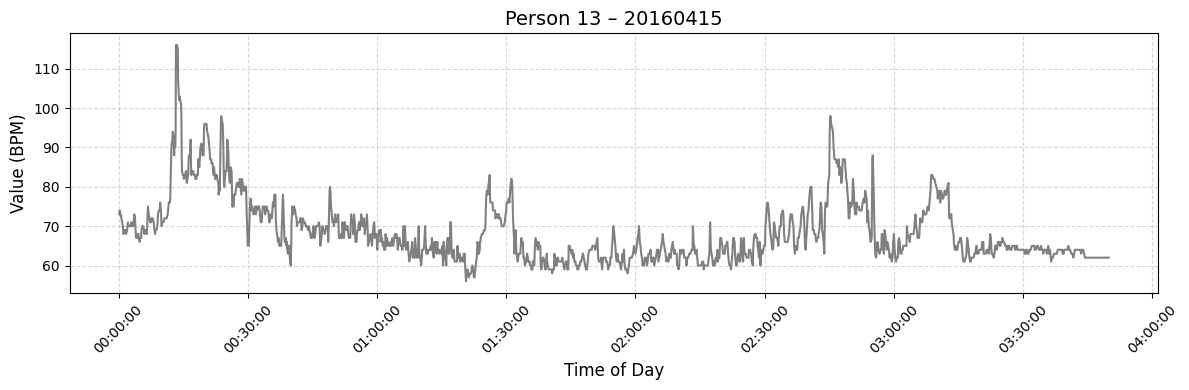

--------------------------------------

                 Id                  Time  Value        Date
2156465  8792009665  4/15/2016 3:52:00 AM     62  2016-04-15
2156466  8792009665  4/15/2016 3:52:15 AM     62  2016-04-15
2156467  8792009665  4/15/2016 3:52:30 AM     62  2016-04-15
2156468  8792009665  4/15/2016 3:52:45 AM     62  2016-04-15
2156469  8792009665  4/15/2016 3:53:00 AM     62  2016-04-15
...             ...                   ...    ...         ...
2157646  8792009665  4/15/2016 7:28:45 AM     66  2016-04-15
2157647  8792009665  4/15/2016 7:29:00 AM     66  2016-04-15
2157648  8792009665  4/15/2016 7:29:15 AM     66  2016-04-15
2157649  8792009665  4/15/2016 7:29:30 AM     66  2016-04-15
2157650  8792009665  4/15/2016 7:29:45 AM     66  2016-04-15

[1186 rows x 4 columns]




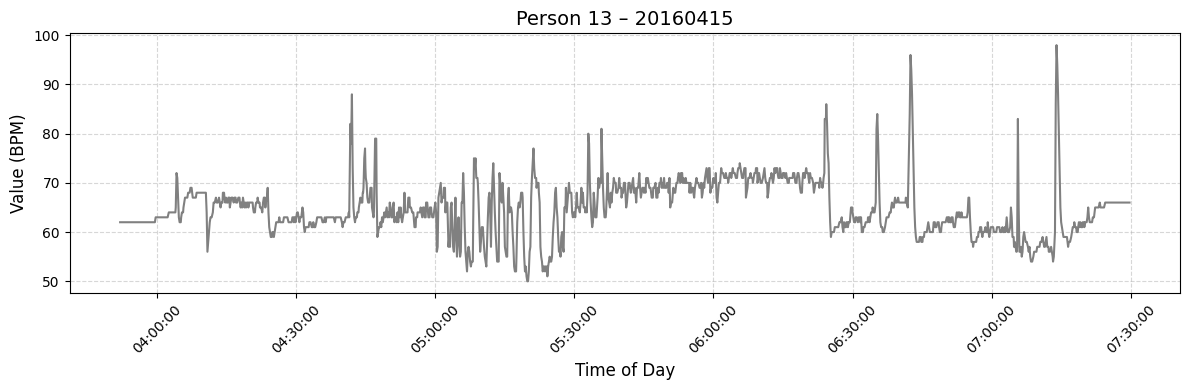

--------------------------------------

                 Id                  Time  Value        Date
2157729  8792009665  4/15/2016 8:08:00 AM     68  2016-04-15
2157730  8792009665  4/15/2016 8:08:10 AM     65  2016-04-15
2157731  8792009665  4/15/2016 8:08:20 AM     63  2016-04-15
2157732  8792009665  4/15/2016 8:08:30 AM     61  2016-04-15
2157733  8792009665  4/15/2016 8:08:40 AM     60  2016-04-15
...             ...                   ...    ...         ...
2158217  8792009665  4/15/2016 9:37:20 AM     62  2016-04-15
2158218  8792009665  4/15/2016 9:37:30 AM     64  2016-04-15
2158219  8792009665  4/15/2016 9:37:40 AM     64  2016-04-15
2158220  8792009665  4/15/2016 9:37:50 AM     63  2016-04-15
2158221  8792009665  4/15/2016 9:38:00 AM     61  2016-04-15

[493 rows x 4 columns]




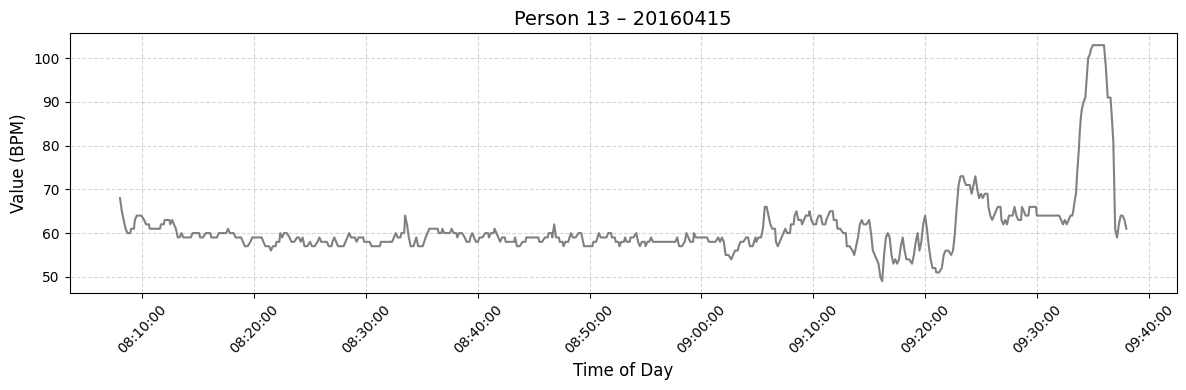

Saved 3 segments for person 13 on 20160415 to '/content/drive/MyDrive/project/p13_20160415'


[                 Id                   Time  Value        Date
 2155068  8792009665  4/15/2016 12:00:10 AM     73  2016-04-15
 2155069  8792009665  4/15/2016 12:00:15 AM     74  2016-04-15
 2155070  8792009665  4/15/2016 12:00:30 AM     73  2016-04-15
 2155071  8792009665  4/15/2016 12:00:40 AM     72  2016-04-15
 2155072  8792009665  4/15/2016 12:00:50 AM     71  2016-04-15
 ...             ...                    ...    ...         ...
 2156455  8792009665   4/15/2016 3:48:50 AM     62  2016-04-15
 2156456  8792009665   4/15/2016 3:49:05 AM     62  2016-04-15
 2156457  8792009665   4/15/2016 3:49:20 AM     62  2016-04-15
 2156458  8792009665   4/15/2016 3:49:35 AM     62  2016-04-15
 2156459  8792009665   4/15/2016 3:49:50 AM     62  2016-04-15
 
 [1392 rows x 4 columns],
                  Id                  Time  Value        Date
 2156465  8792009665  4/15/2016 3:52:00 AM     62  2016-04-15
 2156466  8792009665  4/15/2016 3:52:15 AM     62  2016-04-15
 2156467  8792009665  4/15/201

In [33]:
#print(df_p14_day20160504)
print_day_by_gap(13,20160415,15,120)
save_split_day_by_gap(13, date_str='20160415', max_gap_seconds=15, threshold=120)

In [ ]:
save_split_day_by_gap(4, date_str='20160504', max_gap_seconds=120, save_dir="p4_0504", threshold=120)

Saved 2 segments for person 4 on 20160504 to 'p4_0504'


[                Id                  Time  Value        Date
 405373  4020332650  5/4/2016 12:00:02 AM     70  2016-05-04
 405374  4020332650  5/4/2016 12:00:05 AM     70  2016-05-04
 405375  4020332650  5/4/2016 12:00:08 AM     70  2016-05-04
 405376  4020332650  5/4/2016 12:00:09 AM     69  2016-05-04
 405377  4020332650  5/4/2016 12:00:12 AM     69  2016-05-04
 ...            ...                   ...    ...         ...
 433725  4020332650   5/4/2016 5:52:51 PM    106  2016-05-04
 433726  4020332650   5/4/2016 5:52:53 PM    105  2016-05-04
 433727  4020332650   5/4/2016 5:52:54 PM    104  2016-05-04
 433728  4020332650   5/4/2016 5:52:55 PM    103  2016-05-04
 433729  4020332650   5/4/2016 5:52:58 PM    103  2016-05-04
 
 [28357 rows x 4 columns],
                 Id                  Time  Value        Date
 433730  4020332650   5/4/2016 6:07:08 PM     70  2016-05-04
 433731  4020332650   5/4/2016 6:07:11 PM     70  2016-05-04
 433732  4020332650   5/4/2016 6:07:14 PM     70  2016-0

# Visualization of the data:

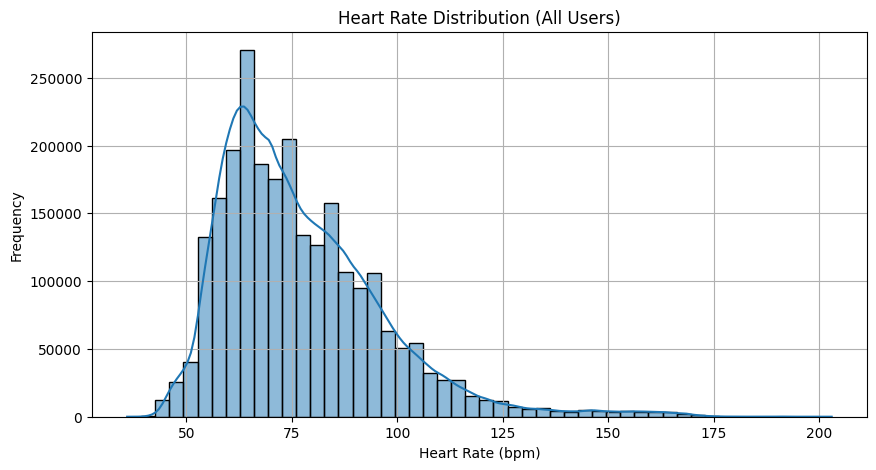

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
df = heartrate_df.copy()
plt.figure(figsize=(10,5))
sns.histplot(df['Value'], bins=50, kde=True)
plt.title("Heart Rate Distribution (All Users)")
plt.xlabel("Heart Rate (bpm)")
plt.ylabel("Frequency")
plt.grid(True)
plt.show()


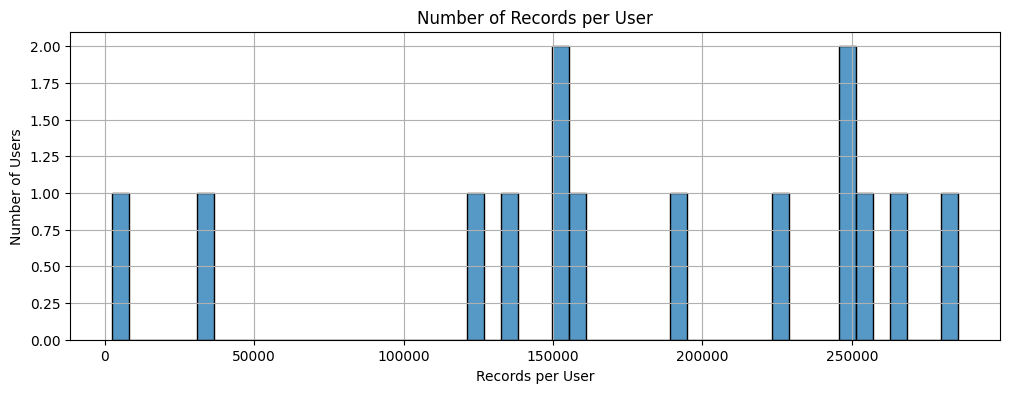

In [ ]:
top_users = df['Id'].value_counts()

plt.figure(figsize=(12,4))
sns.histplot(top_users, bins=50)
plt.title("Number of Records per User")
plt.xlabel("Records per User")
plt.ylabel("Number of Users")
plt.grid(True)
plt.show()


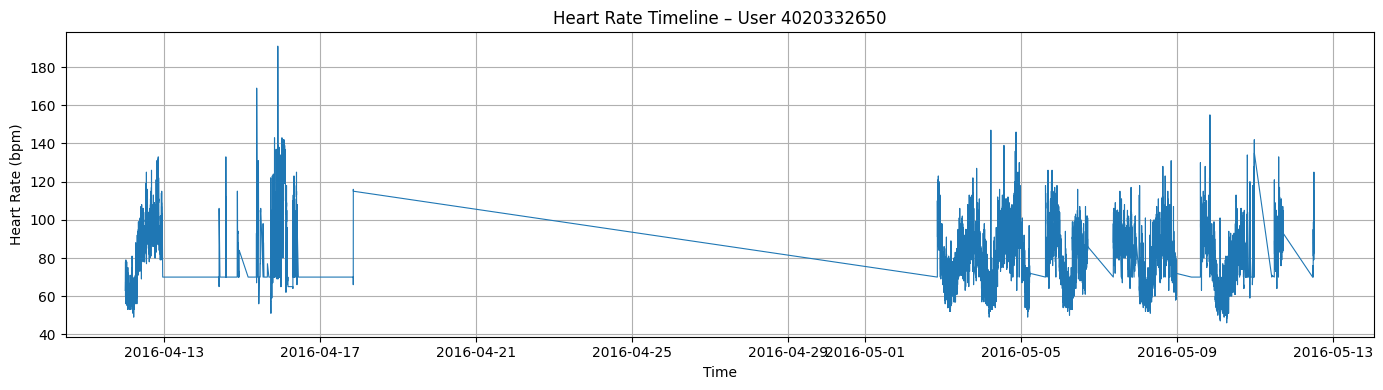

In [ ]:
df['Time'] = pd.to_datetime(df['Time'])

sample_id = df['Id'].value_counts().index[0]
sample_user = df[df['Id'] == sample_id]

plt.figure(figsize=(14,4))
plt.plot(sample_user['Time'], sample_user['Value'], linewidth=0.8)
plt.title(f"Heart Rate Timeline – User {sample_id}")
plt.xlabel("Time")
plt.ylabel("Heart Rate (bpm)")
plt.tight_layout()
plt.grid(True)
plt.show()


#### Shows for each person when he was sampled

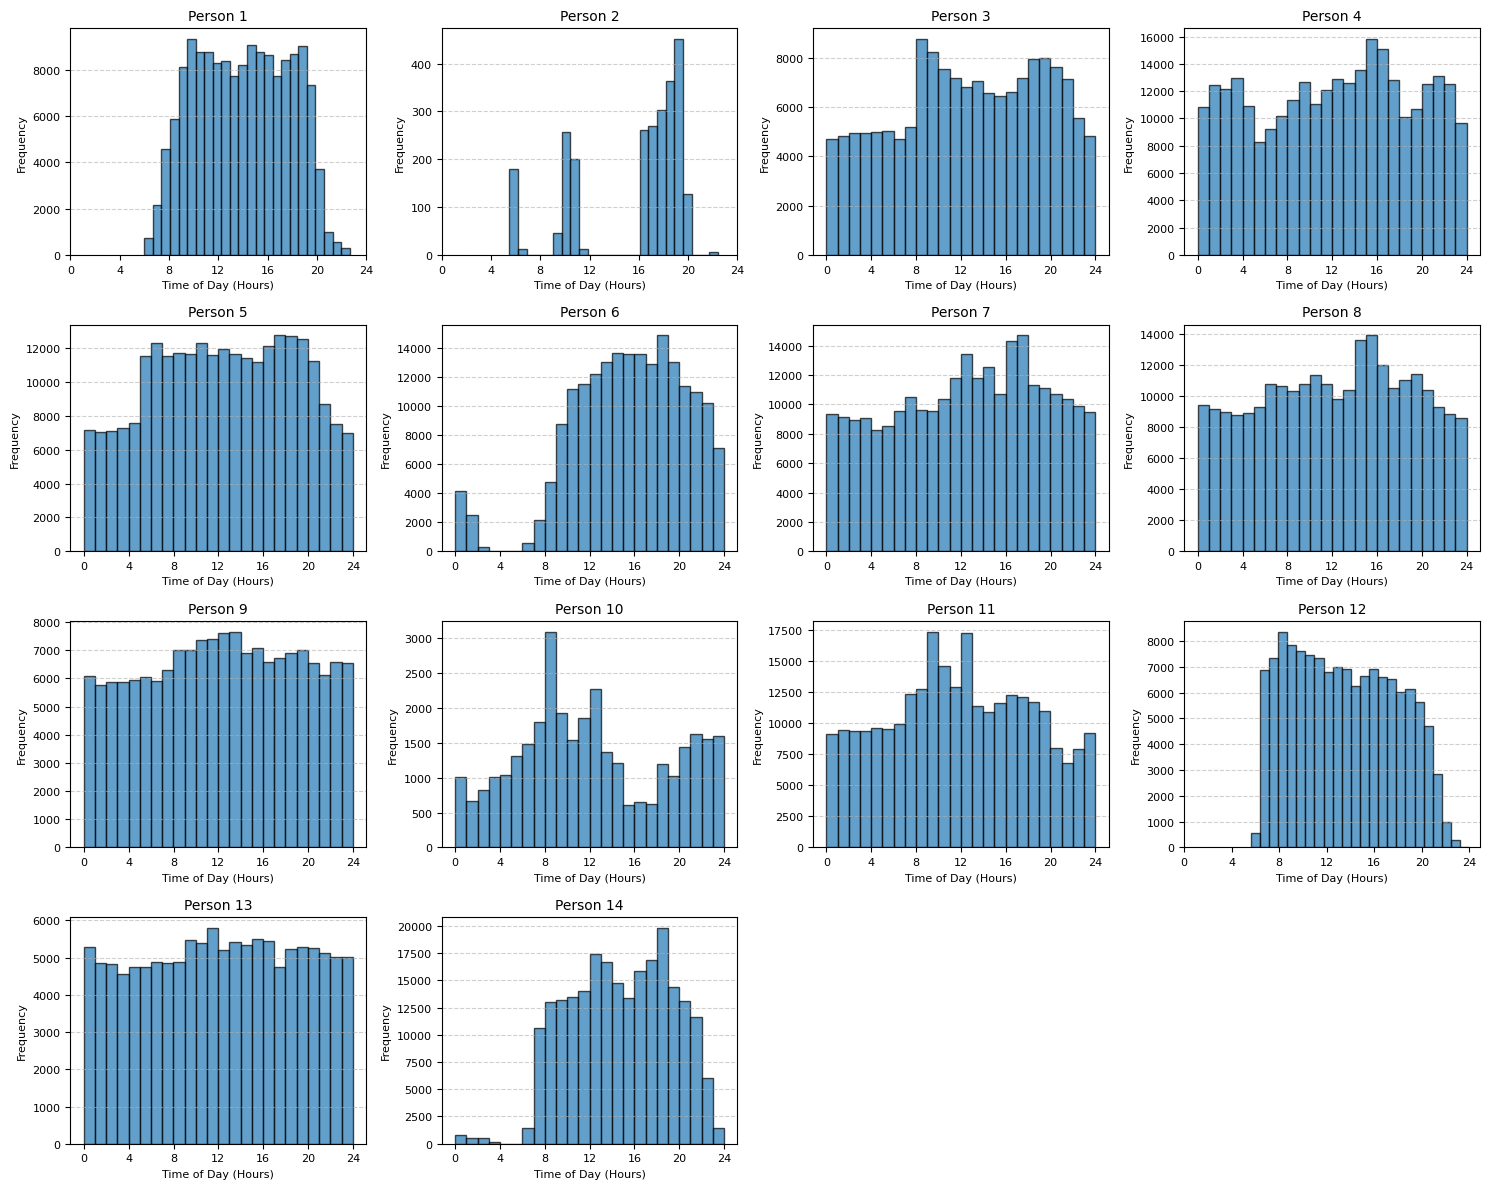

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Ensure 'Time' column is in datetime format
heartrate_df["Time"] = pd.to_datetime(heartrate_df["Time"])

# Sort by Id and Time to ensure correct ordering
heartrate_df = heartrate_df.sort_values(by=["Id", "Time"])

# Get unique IDs
unique_ids = heartrate_df["Id"].unique()

# Set up subplots in a grid
num_ids = len(unique_ids)
cols = 4  # Number of columns in the grid
rows = -(-num_ids // cols)  # Ceiling division to determine rows

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()  # Flatten to handle non-square grids easily

# Plot histogram for each person
for i, id_val in enumerate(unique_ids):
    person_df = heartrate_df[heartrate_df["Id"] == id_val]

    # Convert time to hours for better readability in histogram
    time_hours = person_df["Time"].dt.hour + person_df["Time"].dt.minute / 60

    axes[i].hist(time_hours, bins=24, edgecolor="black", alpha=0.7)  # 24 bins for hours of the day
    axes[i].set_xlabel("Time of Day (Hours)", fontsize=8)
    axes[i].set_ylabel("Frequency", fontsize=8)
    axes[i].set_title(f"Person {i+1}", fontsize=10)
    axes[i].set_xticks(range(0, 25, 4))  # Label x-axis in 4-hour intervals
    axes[i].tick_params(axis='both', which='major', labelsize=8)
    axes[i].grid(axis="y", linestyle="--", alpha=0.6)

# Hide any empty subplots if num_ids < rows * cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


#### plots the signals

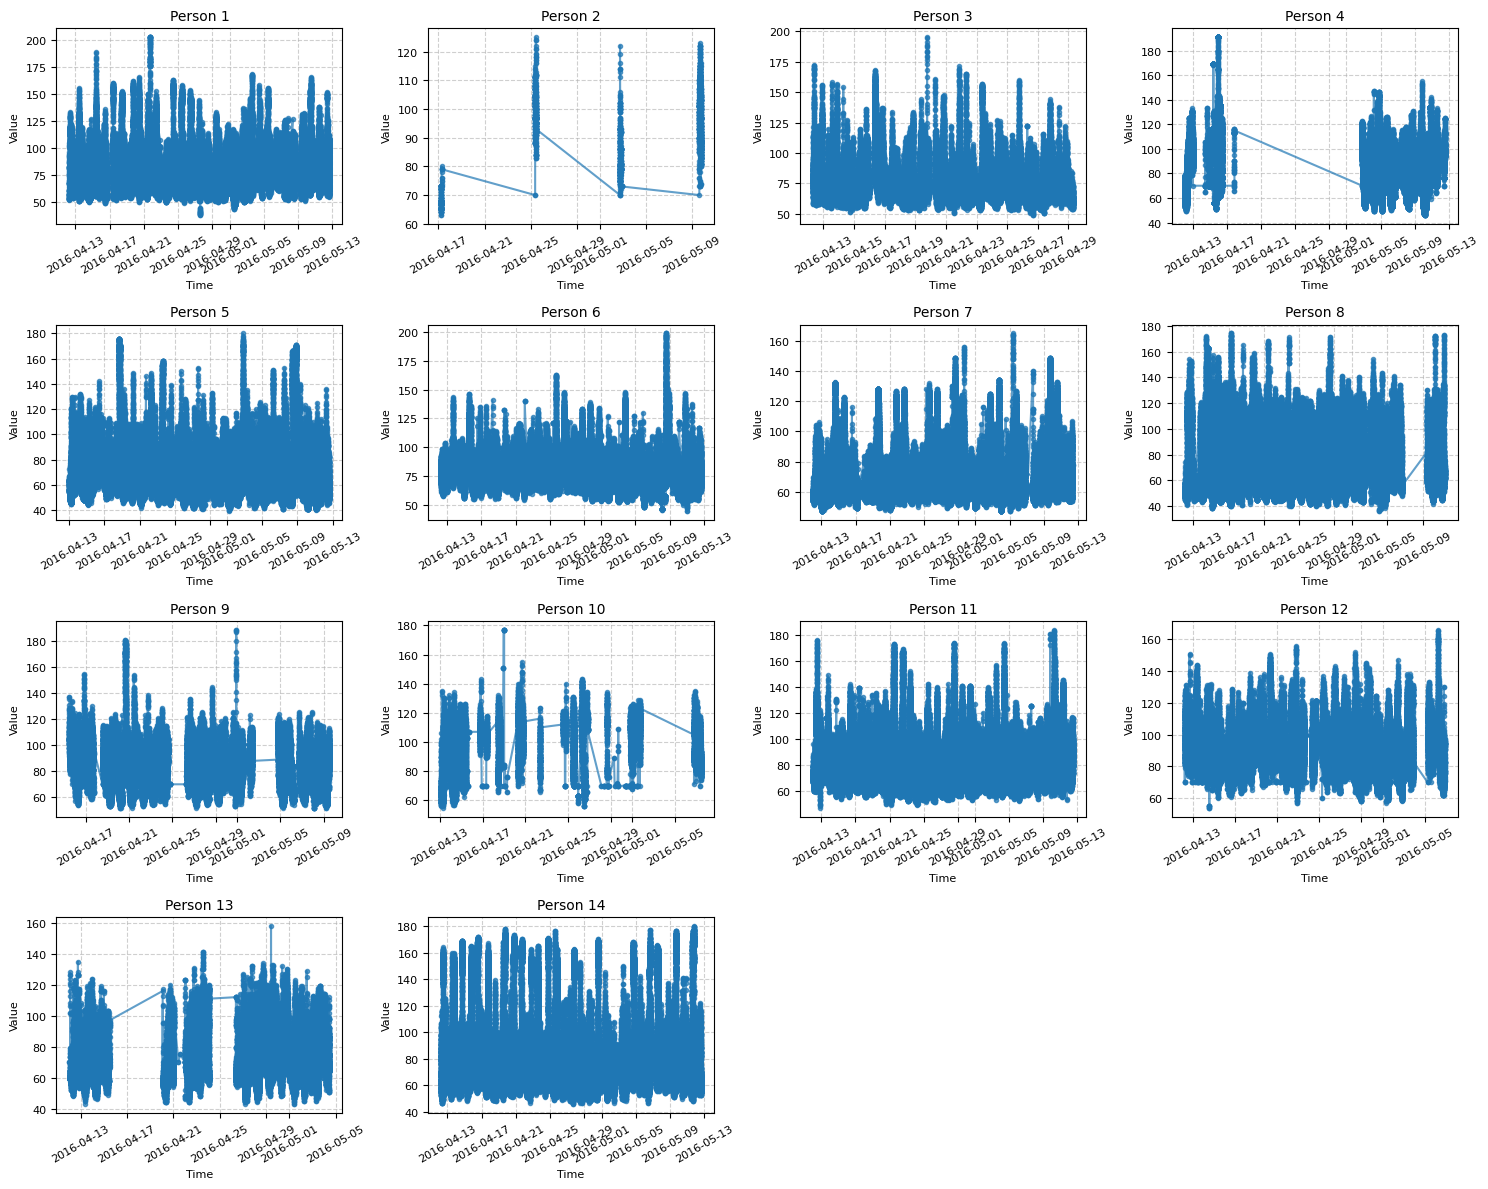

In [ ]:
# Ensure 'Time' column is in datetime format
heartrate_df["Time"] = pd.to_datetime(heartrate_df["Time"])

# Sort by Id and Time to ensure correct ordering
heartrate_df = heartrate_df.sort_values(by=["Id", "Time"])

# Get unique IDs
unique_ids = heartrate_df["Id"].unique()

# Set up subplots in a grid
num_ids = len(unique_ids)
cols = 4  # Number of columns in the grid
rows = -(-num_ids // cols)  # Ceiling division to determine rows

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 3))
axes = axes.flatten()  # Flatten to handle non-square grids easily

# Plot signal for each person
for i, id_val in enumerate(unique_ids):
    person_df = heartrate_df[heartrate_df["Id"] == id_val]

    axes[i].plot(person_df["Time"], person_df["Value"], marker="o", linestyle="-", markersize=3, alpha=0.7)
    axes[i].set_xlabel("Time", fontsize=8)
    axes[i].set_ylabel("Value", fontsize=8)
    axes[i].set_title(f"Person {i+1}", fontsize=10)
    axes[i].tick_params(axis='both', which='major', labelsize=8)
    axes[i].grid(True, linestyle="--", alpha=0.6)

    # Improve readability of time labels
    axes[i].tick_params(axis='x', rotation=30)

# Hide any empty subplots if num_ids < rows * cols
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
